In [2]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from policy import LQRPolicy as policy
from custompendulumenv import CustomPendulumEnv
from memory import memory
import tensorflow as tf

Load environment, policy and buffer. Note, the environment returns a cost instead of a reward, meaning that lower values are better

In [3]:
env = gym.make('CustomPendulum-v0')
pi = policy(env)
buffer = memory()

In [ ]:
s = env.reset()

init_state = np.random.randn(2) * 0.01
print(init_state)
env.env.state = init_state
    
for t in range(250):
    
    env.render()

    u = pi.get_action(s) 

    s_new, rew, done, _ = env.step(u)

    buffer.addTuple([s,u,rew,s_new])

    s = s_new

# Collect data

We do 1000 rollouts a 50 timesteps with the black box policy. Nothing needs to be changed here.

In [4]:
for ep in range(1000):

    s = env.reset()
    
    for t in range(50):
    
        u = pi.get_action(s) 
            
        s_new, rew, done, _ = env.step(u)
        
        buffer.addTuple([s,u,rew,s_new])
        
        s = s_new

# Fit value function

The value function fitting class. Here, you need to fill in the blank parts

In [5]:
import sonnet as snt
class ValueFunction:
    def __init__(self, scope='vf'):
        self._scope = scope
        self._sess = tf.get_default_session() or tf.InteractiveSession()
    
        with tf.variable_scope(self._scope, reuse=tf.AUTO_REUSE):
            self._build_graph()
            
        self._sess.run(tf.variables_initializer(self._global_vars()))
    
    def _build_graph(self):
        self.state = tf.placeholder(dtype=tf.float32, shape=(None, 2), name="state")
        self.target = tf.placeholder(dtype=tf.float32, shape=(None), name="target")
        
        net_arch1 = snt.Linear(output_size=100,
                              name='q_net_h1',
                              initializers={'w': tf.truncated_normal_initializer(stddev=1.0),
                                            'b': tf.truncated_normal_initializer(stddev=1.0)})

        net_arch2 = snt.Linear(output_size=100,
                               name='q_net_h2',
                               initializers={'w': tf.truncated_normal_initializer(stddev=1.0),
                                             'b': tf.truncated_normal_initializer(stddev=1.0)})
        net_arch3 = snt.Linear(output_size=1,
                              name='q_net_h3',
                              initializers={'w': tf.truncated_normal_initializer(stddev=1.0),
                                            'b': tf.truncated_normal_initializer(stddev=1.0)})

        self.h = tf.nn.relu(net_arch1(self.state))
        self.h = tf.nn.relu(net_arch2(self.h))
        self.h = tf.nn.relu(net_arch3(self.h))
        self.output = tf.squeeze(self.h)
        
        self.output = tf.squeeze(self.h)
        
        self.loss = tf.reduce_mean(tf.square(self.output - self.target))
        self.optim = tf.train.AdamOptimizer()
        self.train_op = self.optim.minimize(self.loss)
        
    def _vars(self, scope=''):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self._scope + '/' + scope)
    
    def _global_vars(self, scope=''):
        return tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=self._scope + '/' + scope)
    
    def predict(self, state):
        fddct = {self.state: state}
        return self._sess.run([self.output], feed_dict=fddct)
    
    def fit(self, state, target, iteration=1):
        fddct = {self.state: state, self.target: target}
        for _ in range(iteration):
            _, loss = self._sess.run([self.train_op, self.loss], feed_dict=fddct)
        return loss

/usr/lib/python3.7/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)


In [6]:
vfunc = ValueFunction()

Fitting routine of the value function. Fill in the blank parts.

In [7]:
plt_fit = []
iter_fit = 1000
for i in range(iter_fit):

    # sample from the replay buffer
    data=buffer.sample(batch=50)
    xs = np.stack(data[:,0]) # s_t
    xps = np.stack(data[:,3]) # s_t+1
    gs = np.stack(data[:,2]) # rew
    
    vk = vfunc.predict(xs)
    vkplus = vfunc.predict(xps)

    # target
    gamma=0.9
    td_target = gs+gamma*np.squeeze(vkplus)

    # optimize the lsq objective
    fit_loss = vfunc.fit(xs, td_target, iteration=1)
    plt_fit.append(fit_loss)
    
# plot the loss
plt.figure()
plt.plot(range(len(plt_fit)),plt_fit)
plt.draw()

# Visualize

Visualization of the value function. Nothing needs to be changed here.

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [9]:
def get_obj(x):
    if len(np.asarray(x).shape) < 2:
        x=np.asarray(x).reshape(1,2)
    return np.squeeze(vfunc.predict(x))

In [10]:
plt.rcParams.update({'font.size': 12})

<IPython.core.display.Javascript object>


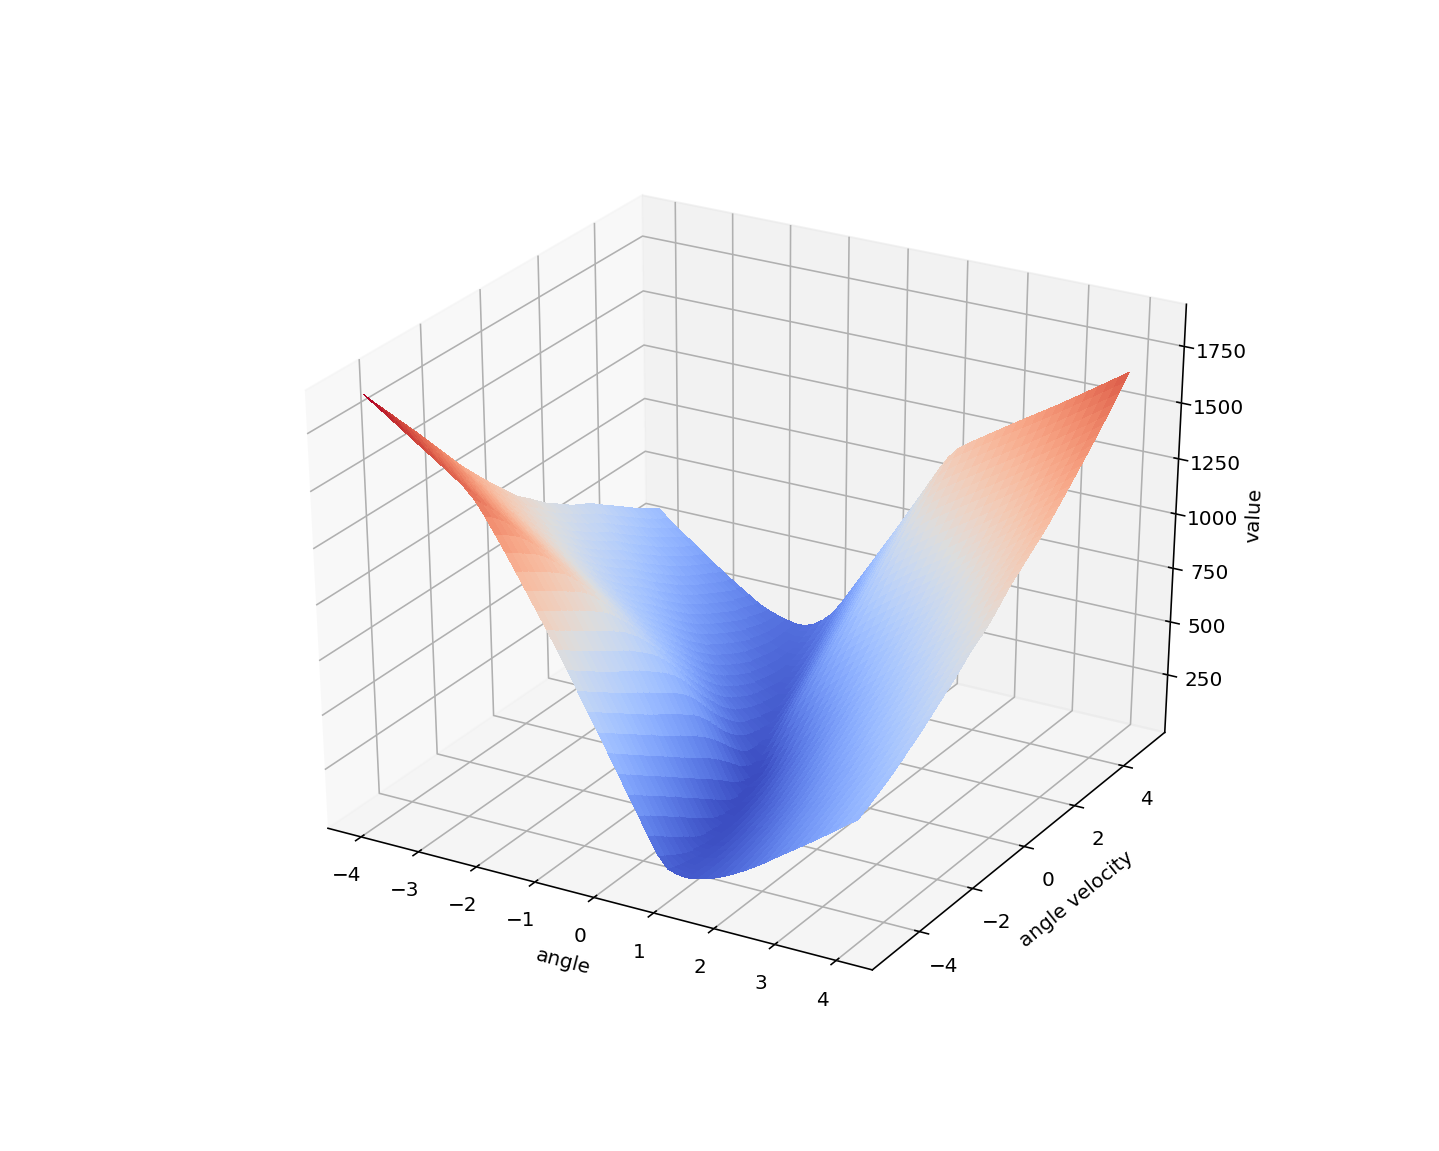

'\nbeautiful plot!\n'

In [11]:
xxs =np.linspace(-4,4)
yys =np.linspace(-5,5)

XX,YY=np.meshgrid(xxs,yys)

dots=np.asarray([XX.ravel(),YY.ravel()]).T

scores = get_obj(dots)
scores = scores.reshape(XX.shape)

%matplotlib notebook
fig = plt.figure(figsize=[10,8])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(XX, YY, scores, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel('angle')
ax.set_ylabel('angle velocity')
ax.set_zlabel('value')

'''
beautiful plot!
'''

# plt.colorbar(cmap=cm.coolwarm)